# LSTM training with prior

This notebook shows how to train a Noisy LSTM with a trainable prior. The training should consist of the following pseudo-code:

```python
for epoch in range(epochs):
    for batch in data:
        # use the prior to generate samples
        # replace batch.targets with the prior samples
        # train the LSTM with the new batch
    
    # train the prior:
    if epoch is in the interval [1, N]:
        # generate prior samples
        # use prior samples to generate lstm datapoints
        # create vector of cost function values from lstm datapoints
        # create vector of probs using softmax of cost function values
        # train the prior with the prior samples and their corresponding probs
```

To achieve this, we will use the `TrainingSchedule` and `Callback` tools available in `orquestra-qml-core`.

In [1]:
from orquestra.qml.api import TrainingSchedule, Callback, TrainCache, convert_to_torch, GenerativeModel

class ModifyTargetsCallback(Callback):
    """
    This is a callback that modifies the targets of the training data by replacing
    them with samples from a prior.
    """
    def __init__(self, prior: GenerativeModel, seed: int = 0):
        self.prior = prior
        self._seed = seed

    def on_train_begin(self, cache: TrainCache):
        cache.remove_reserved_key("_train_batch")
        cache._store_train_data_flag = True

    def on_train_step_begin(self, step: int, cache: TrainCache):
        latest_batch = cache.latest_train_batch
        assert latest_batch is not None
        num_samples = latest_batch.data.shape[0]
        prior_samples = convert_to_torch(
            self.prior.generate(num_samples, random_seed=self._seed)
        ).float()
        self._seed += 1
        latest_batch.targets = prior_samples

class FinalBatchSchedule(TrainingSchedule):
    def __init__(self, final_batch: int) -> None:
        """
        A custom training schedule that only trains the prior at the last batch of
        the main training loop.
        """
        super().__init__()
        self.final_batch = final_batch

    def is_enabled(
        self,
        *,
        epoch: int,
        step: int,
        batch_index: int,
    ) -> bool:
        if batch_index != self.final_batch:
            return False
        return True

In [2]:
from orquestra.drug.discovery.encoding import Selfies
from orquestra.drug.discovery.validator import  ConditionFilters
from orquestra.drug.discovery.validator import GeneralFilter, PainFilter, WehiMCFilter

selfies = Selfies.from_smiles_csv(
    "/Users/mohamad/workspace/repos/orquestra-drug-discovery/notebook/data/KRAS_G12D_inhibitors.csv"
)

Loading Selfies From CSV: 100%|██████████| 453/453 [00:00<00:00, 1417.11it/s]


In [3]:
filter_lists=[PainFilter(),GeneralFilter()]
weight_lists=[5.0,1.1]


In [4]:
len(selfies.as_dataset())
selfies.pad_index

1

In [5]:
from orquestra.qml.api.trainer import TrainCache, TrainerBehaviourControl
from orquestra.qml.data_loaders import new_data_loader
from orquestra.qml.models.rbm.jx import RBM
from orquestra.qml.experimental.models.recurrent.lstm.th import NoisyLSTM
from orquestra.qml.trainers import SimpleTrainer, AdversarialTrainer
import numpy as np
from orquestra.qml.api import convert_to_numpy


class RecordCostFn(Callback):
    def __init__(self,filter_lists,weight_lists):
        self._current_costs = []
        self.filter = ConditionFilters(filter_lists=filter_lists,weight_lists=weight_lists)

    def __call__(self, tokenstring):
        tokenstring = convert_to_numpy(tokenstring).astype(int).reshape(1, -1)
        # Enforces the last two bits to be 1 because having zeros costs more.
        selfies_string = selfies.selfie_to_smiles(selfies.decode(tokenstring))
        self.filter.compute_reward(selfies_string[0])
        cost = -self.filter.compute_reward(selfies_string[0])[1]
        self._current_costs.append(cost)
        return cost
    
    def on_epoch_end(self, epoch: int, cache: TrainCache, control: TrainerBehaviourControl):
        invalid_strings = np.sum(np.asarray(self._current_costs) == 0)
        total_strings = len(self._current_costs)
        cache.update_history({"cost_fn": np.mean(self._current_costs).item(), "invalid_samples_percentage": invalid_strings/total_strings * 100})
        self.current_costs = []
    
    

prior_bits = 16
prior_n_epochs = 10
n_epochs = 2
record_cost_fn = RecordCostFn(filter_lists, weight_lists)
rbm = RBM(n_visible=prior_bits, n_hidden=prior_bits, random_seed=0)
lstm = NoisyLSTM(
    vocab_size=selfies.n_tokens,
    max_seq_len=selfies.max_length, 
    sos_token_index=0, 
    padding_token_index=selfies.pad_index,
    prior_sample_dim=prior_bits, 
    prior=rbm,
    prior_trainer=SimpleTrainer(),
    prior_batch_size=-1,
    n_prior_samples=1024,
    prior_n_epochs=prior_n_epochs,
    cost_fn=record_cost_fn,
    cost_fn_temperature=1.0,
    random_seed=0,
)

# dataloader = CardinalityDataLoader(n_qubits=bits, cardinality=bits//2, batch_size=-1)
# batch = next(iter(dataloader))
# # We use dummy data for the targets:
# batch.targets = batch.data[:, :prior_bits]
# dataloader = new_data_loader(batch.data, targets=batch.targets, batch_size=8).shuffle(seed=33)
dataset = selfies.as_tensor()
dummy_targets = convert_to_torch(np.ones((len(dataset), prior_bits)))
dataloader = new_data_loader(dataset, targets=dummy_targets, batch_size=8).shuffle(seed=33)
# Compute validity as well:

schedule = FinalBatchSchedule(final_batch=dataloader.n_batches-1)
callback = ModifyTargetsCallback(prior=rbm, seed=98735)

trainer = AdversarialTrainer(prior_training_schedule=schedule)
result = trainer.train(lstm, dataloader, n_epochs=n_epochs, callbacks=[callback, record_cost_fn])

Epoch 1 / 2: :   0%|          | 0/114 batches [00:00<?, ?batches/s ]/Users/mohamad/workspace/repos/orquestra-qml-core/src/orquestra/qml/api/tensor.py:83: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  tensor = torch.from_numpy(np.asarray(tensor))
Filtered 0 / 1. passed=0,frac=0.0: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]
[19:43:05] WARNING: not removing hydrogen atom without neighbors
[19:43:05] WARNING: not removing hydrogen atom without neighbors
Filtered 0 / 1. passed=0,frac=0.0: 100%|██████████| 1/1 [00:00<00:00, 23.07it/s]
[19:43:09] WARNING: not removing hydrogen atom with

In [6]:
samples = lstm.generate(10, random_seed=23)

In [7]:
d = samples.numpy().astype(int)

In [9]:
selfies.selfie_to_smiles(selfies.decode(d))

['CCCC=CC(=C)C',
 '[C@H1]=O',
 'CN=C=C',
 'C1=CCC#C1',
 '',
 'Cl[C@H1]',
 '[NH1+2]',
 'C1N(C)C=NOCC=N1',
 '[C@@H1]O',
 '[C@@]']

In [10]:
result.plot_history_metrics("loss", averaging_period=dataloader.n_batches)

OptionalDependencyNotFoundError: Dependency matplotlib, which is part of the viz set of optional dependencies, is not found. In order to install, run `pip install .[viz]` or `orq-qml update --extras viz`

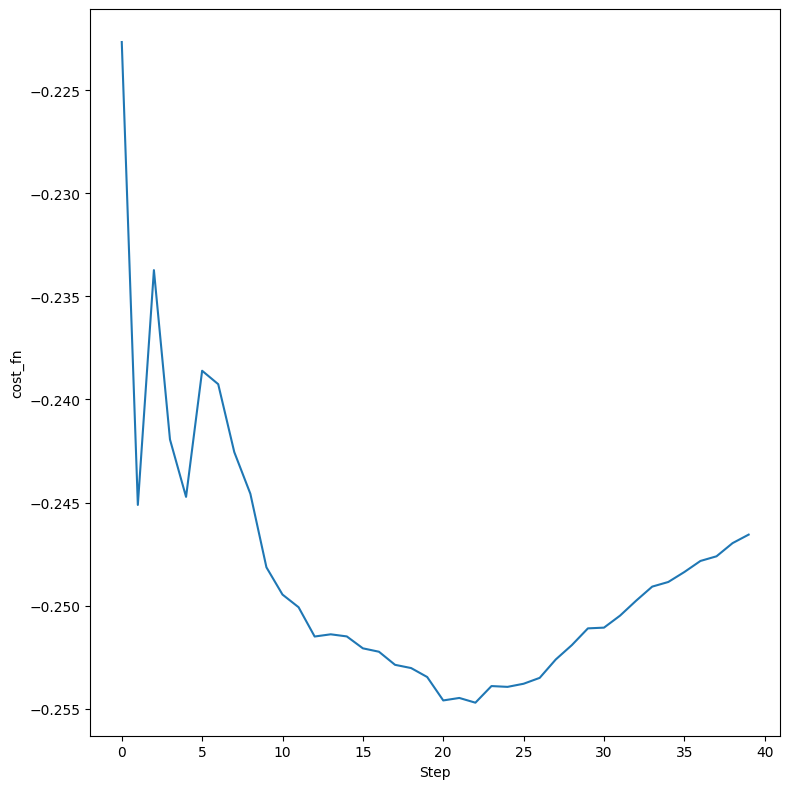

In [11]:
result.plot_history_metrics("cost_fn")